In [1]:
from datasets import load_dataset

ds = load_dataset("mrjunos/depression-reddit-cleaned")

In [127]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 7731
    })
})


In [128]:
# print first 5 examples
train = ds["train"]
for i in range(5):
    print(train[i])

{'text': 'we understand that most people who reply immediately to an op with an invitation to talk privately mean only to help but this type of response usually lead to either disappointment or disaster it usually work out quite differently here than when you say pm me anytime in a casual social context we have huge admiration and appreciation for the goodwill and good citizenship of so many of you who support others here and flag inappropriate content even more so because we know that so many of you are struggling yourselves we re hard at work behind the scene on more information and resource to make it easier to give and get quality help here this is just a small start our new wiki page explains in detail why it s much better to respond in public comment at least until you ve gotten to know someone it will be maintained at r depression wiki private contact and the full text of the current version is below summary anyone who while acting a a helper invite or accepts private contact i 

In [129]:
import pandas as pd

df = pd.DataFrame(train)
df.head()

,text,label
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7731 entries, 0 to 7730
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7731 non-null   object
 1   label   7731 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 120.9+ KB


In [131]:
print(f'Dataframe has {df.shape[0]} rows and {df.shape[1]} columns')

Dataframe has 7731 rows and 2 columns


In [132]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [133]:
df['label'].value_counts()

label
0    3900
1    3831
Name: count, dtype: int64

In [134]:
import matplotlib.pyplot as plt
import seaborn as sns

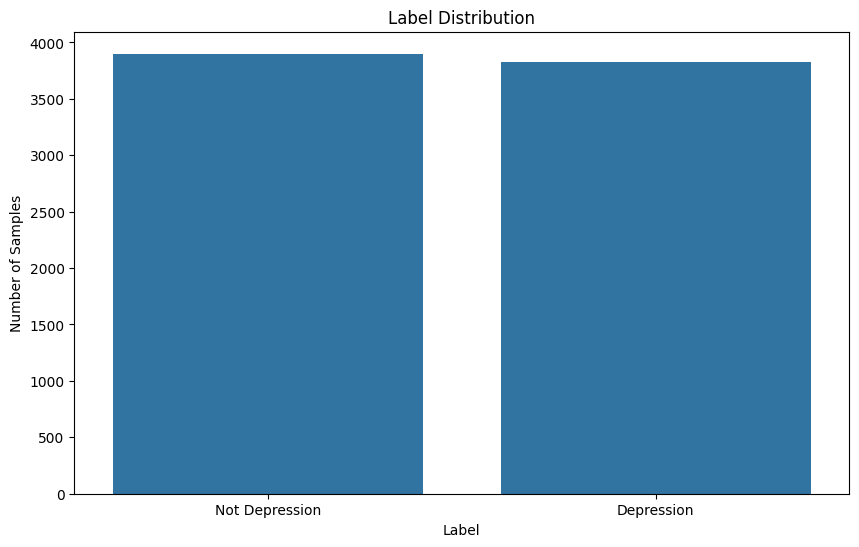

In [135]:
# get label distribution
label_dist = df['label'].value_counts()

# rename the index
label_dist = label_dist.rename(index={0: 'Not Depression', 1: 'Depression'})

# plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_dist.index, y=label_dist.values)
plt.title('Label Distribution')
plt.ylabel('Number of Samples')
plt.xlabel('Label')
plt.show()

## Preprocessing

In [136]:
import re
import string
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk

In [137]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [138]:
def prepocess_text(text):
    # lowercase
    text = text.lower()
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove links
    text = re.sub(r'http\S+', '', text)
    # remove unnecessary white spaces
    text = text.strip()
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text) # tokenize the text
    text = [i for i in word_tokens if not i in stop_words]

    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text]

    text = ' '.join(text)

    return text

In [139]:
from sklearn.model_selection import train_test_split

In [140]:
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.2)

In [141]:
X_train_prep = X_train.apply(prepocess_text)
X_val_prep = X_val.apply(prepocess_text)

In [142]:
print(X_train[0])
print(X_train_prep[0])

we understand that most people who reply immediately to an op with an invitation to talk privately mean only to help but this type of response usually lead to either disappointment or disaster it usually work out quite differently here than when you say pm me anytime in a casual social context we have huge admiration and appreciation for the goodwill and good citizenship of so many of you who support others here and flag inappropriate content even more so because we know that so many of you are struggling yourselves we re hard at work behind the scene on more information and resource to make it easier to give and get quality help here this is just a small start our new wiki page explains in detail why it s much better to respond in public comment at least until you ve gotten to know someone it will be maintained at r depression wiki private contact and the full text of the current version is below summary anyone who while acting a a helper invite or accepts private contact i e pm chat 

## Representation Learning

In [143]:
from transformers import AutoTokenizer, AutoModel
import torch

In [144]:
# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert/distilroberta-base')
model = AutoModel.from_pretrained('distilbert/distilroberta-base')

In [145]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [146]:
# batch encode the text
batch_size = 32
embeddings_train = []

In [ ]:
def get_embeddings(texts, tokenizer, model, device, batch_size=32):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size].tolist()
        # encode the batch of texts
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128).to(device)
        # get the embeddings
        with torch.no_grad():
            output = model(**inputs)
        # we only need the output of the [CLS] token
        batch_embeddings = output.last_hidden_state[:, 0, :].cpu().numpy()
        # add the embeddings to the list
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

In [148]:
import os

if os.path.exists('depression-cleaned_embeddings_train.npy'):
    embeddings_train = np.load('depression-cleaned_embeddings_train.npy')
else:
    embeddings_train = get_embeddings(X_train_prep, tokenizer, model, device, batch_size)
    np.save('depression-cleaned_embeddings_train.npy', embeddings_train)

if os.path.exists('depression-cleaned_embeddings_val.npy'):
    embeddings_val = np.load('depression-cleaned_embeddings_val.npy')
else:
    embeddings_val = get_embeddings(X_val_prep, tokenizer, model, device, batch_size)
    np.save('depression-cleaned_embeddings_val.npy', embeddings_val)

In [149]:
print(embeddings_train.shape)
print(embeddings_val.shape)

(6184, 768)
(1547, 768)


## Classification

In [172]:
# Train a classifier, in this case  GRU model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC # AUC is the metric we are interested in, this is the area under the ROC curve

In [ ]:
# Define a Dense model for sentence-level embeddings
model = Sequential([
    # 2 Dense layers with dropout
    Dense(128, activation='relu', input_shape=(embeddings_train.shape[1],)),  # Input shape matches the embedding size
    Dropout(0.5),  # Dropout layer to prevent overfitting
    Dense(64, activation='relu'),
    Dropout(0.5),
    # Output layer
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.00001),
    metrics=['accuracy', AUC()]
)

c:\Users\User\Documents\Honours\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [187]:
model.fit(
    embeddings_train, y_train,
    validation_data=(embeddings_val, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5087 - auc_26: 0.5058 - loss: 0.7213 - val_accuracy: 0.5094 - val_auc_26: 0.6531 - val_loss: 0.6915
Epoch 2/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4990 - auc_26: 0.4927 - loss: 0.6978 - val_accuracy: 0.5094 - val_auc_26: 0.3033 - val_loss: 0.6952
Epoch 3/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4920 - auc_26: 0.5035 - loss: 0.6941 - val_accuracy: 0.7421 - val_auc_26: 0.6549 - val_loss: 0.6912
Epoch 4/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4804 - auc_26: 0.4783 - loss: 0.6956 - val_accuracy: 0.5094 - val_auc_26: 0.8224 - val_loss: 0.6908
Epoch 5/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5114 - auc_26: 0.4942 - loss: 0.6930 - val_accuracy: 0.7253 - val_auc_26: 0.7894 - val_loss: 0.6900
Epoch 6/10
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4999 - auc_26: 0.5009 - loss: 0.6934 - val_accuracy: 0.5094 - val_auc_26: 0.5020 - val_loss: 0.6927
Epoc

In [188]:
print("Variance of the embeddings_train: ", np.var(embeddings_train))
print("Variance of the embeddings_val: ", np.var(embeddings_val))

Variance of the embeddings_train:  0.26004666
Variance of the embeddings_val:  0.2598177


In [163]:
from keras.callbacks import ReduceLROnPlateau

In [164]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

In [165]:
model.fit(embeddings_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[lr_scheduler])

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4932 - auc_20: 0.4878 - loss: 0.6956 - val_accuracy: 0.4729 - val_auc_20: 0.5000 - val_loss: 0.6955 - learning_rate: 0.2000
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5014 - auc_20: 0.4899 - loss: 0.6955 - val_accuracy: 0.5271 - val_auc_20: 0.5000 - val_loss: 0.7168 - learning_rate: 0.2000
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4986 - auc_20: 0.4931 - loss: 0.7008 - val_accuracy: 0.4729 - val_auc_20: 0.5000 - val_loss: 0.6935 - learning_rate: 0.2000
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4954 - auc_20: 0.4917 - loss: 0.6963 - val_accuracy: 0.4729 - val_auc_20: 0.5000 - val_loss: 0.7098 - learning_rate: 0.2000
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4872 - auc_20: 0.4730 - loss: 0.6999 - val_accuracy: 0.4729 - val_auc_20: 0.5000 - val_loss: 0.7005 - learning_rate: 0.2000
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste